<a href="https://colab.research.google.com/github/DannMacias/corn-leaf-disease-detection/blob/main/01_disease_detection_base_model_effnetb2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Corn leaf disease detection - Using EfficientNetB2 </b>

[**Corn or Maize Leaf Disease Dataset**](https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset) is a dataset for classification of corn or maize plant leaf disease.

**Dataset Description**
* 0 - Common Rust (1306 images)
* 1 - Gray Leaf Spot (574 images)
* 2 - Blight (1146 images)
* 3 - Healthy (1162 images)

This dataset has been made using the popular [PlantVillage](https://www.kaggle.com/datasets/emmarex/plantdisease) and [PlantDoc](https://github.com/pratikkayal/PlantDoc-Dataset) datasets. 

The goal of this notebook is create a model using EfficientNetB2 (transfer learning) that is capable of detect disease in corn leaves.

**Citation**

1. Singh D, Jain N, Jain P, Kayal P, Kumawat S, Batra N. PlantDoc: a dataset for visual plant disease detection. InProceedings of the 7th ACM IKDD CoDS and 25th COMAD 2020 Jan 5 (pp. 249-253).

2. J, ARUN PANDIAN; GOPAL, GEETHARAMANI (2019), “Data for: Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network”, Mendeley Data, V1, doi: 10.17632/tywbtsjrjv.1

# 0. Getting setup

In [1]:
# Import dependencies
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
# Setting device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Need the following libraries to make a confusion matrix.
* [torchmetrics](https://torchmetrics.readthedocs.io/en/stable/).
* [mlxtend](https://rasbt.github.io/mlxtend/api_modules/mlxtend.plotting/plot_confusion_matrix/).

In [3]:
# See if torchmetrics and mlxtend exist, if not, install it
try:
  import torchmetrics, mlxtend
  print(f"torchmetrics version: {torchmetrics.__version__}")
  print(f"mlxtend version: {mlxtend.__version__}")
except:
  print("[INFO] Couldn't find torchmetrics and mlxtend. Intalling it...")
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"torchmetrics version: {torchmetrics.__version__}")
  print(f"mlxtend version: {mlxtend.__version__}")  

[INFO] Couldn't find torchmetrics and mlxtend. Intalling it...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
torchmetrics version: 0.11.1
mlxtend version: 0.21.0


In [4]:
# Get helper functions (for training and make predictions) from GitHub repo
# See https://github.com/DannMacias/corn-leaf-disease-detection
# Clone the repo
!git clone https://github.com/DannMacias/corn-leaf-disease-detection

# Move the folder helper_functions
!mv corn-leaf-disease-detection/helper_functions .

# Remove the remaining files from the repo of Google Colab
!rm -rf corn-leaf-disease-detection
from helper_functions import engine, predictions, utils

Cloning into 'corn-leaf-disease-detection'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 50 (delta 18), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (50/50), 12.97 KiB | 1021.00 KiB/s, done.


# 1. Get the data

I will use the dataset of [**Corn or Maize Leaf Disease Dataset**](https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset), previously download in Google Drive.

In [5]:
# Get the data from Google Drive
!unzip /content/drive/MyDrive/Pytorch_notes/corn-leaf-image-classification/corn-leaf-disease.zip > /dev/null

In [6]:
# Set the data path
data_path = "/content/data"

Because the data is nos separated, it should be splitted into `train` and `test` sets. To do that, I used [splitfolders](https://pypi.org/project/split-folders/) library and splitted the data into train (80%) and test (20%)

In [7]:
# Import splitfolders or installing it
try:
  import splitfolders
except:
  !pip install split-folders
  import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Split the data in train (80%) and test (20%)
splitfolders.ratio(input = data_path,
                   output = "splitted_data",
                   seed = 42,
                   ratio = (0.8, 0.2), # 80% train and 20% test
                   group_prefix = None,
                   move = False)

Copying files: 4188 files [00:00, 5756.54 files/s]


In [9]:
# Setup train and test directories
train_dir = "/content/splitted_data/train"
test_dir = "/content/splitted_data/val"

train_dir, test_dir

('/content/splitted_data/train', '/content/splitted_data/val')

# 2. Create datasets and DataLoaders

To create the datasets, and since I will use transfer learning, I will first create the function `create_effnetb2_model` to create the model (EfficientNetB2) and obtain the transformations, which I will then use in the creation of the datasets.

In [10]:
# Create an EffNetB2 feature extractor function
def create_effnetb2_model(num_classes: int = 4,
                          seed: int = 42):
  
  # Create EfficientB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p = 0.3, inplace = True),
      nn.Linear(in_features = 1408, 
                out_features = num_classes,
                bias = True)
  )

  return model, transforms

In [11]:
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes = 4,
                                                      seed = 42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

In [12]:
# See the transforms of effnetb2 model
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

To keep things simple in this first experiment, I will not use data augmentation.

## 2.1. Create Datasets and DataLoaders

In [13]:
# Create datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = effnetb2_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = effnetb2_transforms)

# Get the class names
class_names = train_data.classes

In [14]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # Use the total number of CPUs 

# Create DataLoaders
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS,
                              pin_memory = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False, # No shuffle on test dataloader
                             num_workers = NUM_WORKERS,
                             pin_memory = True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f057685dc70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f057685ddf0>)

## 2.2. Get the number of images per class in train and test datasets

In [15]:
# Train images per classes
from collections import Counter

# Index to class mapping
idx_to_class = {v:k for k, v in train_data.class_to_idx.items()}
idx_distribution = dict(Counter(train_data.targets))
class_distribution = {idx_to_class[k]:v for k, v in idx_distribution.items()}
print(class_distribution)

{'Blight': 916, 'Common_Rust': 1044, 'Gray_Leaf_Spot': 459, 'Healthy': 929}


In [16]:
# Test images per classes
idx_to_class = {v:k for k, v in test_data.class_to_idx.items()}
idx_distribution = dict(Counter(test_data.targets))
class_distribution = {idx_to_class[k]:v for k, v in idx_distribution.items()}
print(class_distribution)

{'Blight': 230, 'Common_Rust': 262, 'Gray_Leaf_Spot': 115, 'Healthy': 233}


As you can see, we have a problem with class balance. However, for the moment I will continue. The class imbalance will be explored in future experiments.

## 2.3. Visualize the images in the DataLoaders

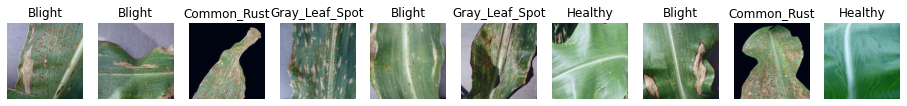

In [17]:
# View images in train dataloader using view_dataloader_images from utils.py
utils.view_dataloader_images(dataloader = train_dataloader,
                             class_names = class_names,
                             num_images = 10)

# 3. Train the model

In [18]:
# Setup loss function and optimizer
LEARNING_RATE = 0.001

loss_fn = torch.nn.CrossEntropyLoss() # for multi-class classification task
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = LEARNING_RATE)

In [19]:
# Train the model using engine.py from GitHub repo
# Start the timer
from timeit import default_timer as timer
start_time = timer()

effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader,
                                test_dataloader = test_dataloader,
                                optimizer = optimizer,
                                loss_fn = loss_fn,
                                epochs = 10,
                                device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6013 | train_acc: 0.8036 | test_loss: 0.3606 | test_acc: 0.8947
Epoch: 2 | train_loss: 0.3177 | train_acc: 0.8910 | test_loss: 0.2853 | test_acc: 0.9062
Epoch: 3 | train_loss: 0.2678 | train_acc: 0.9039 | test_loss: 0.2579 | test_acc: 0.9120
Epoch: 4 | train_loss: 0.2460 | train_acc: 0.9113 | test_loss: 0.2457 | test_acc: 0.9039
Epoch: 5 | train_loss: 0.2293 | train_acc: 0.9160 | test_loss: 0.2382 | test_acc: 0.9074
Epoch: 6 | train_loss: 0.2062 | train_acc: 0.9234 | test_loss: 0.2296 | test_acc: 0.9086
Epoch: 7 | train_loss: 0.2060 | train_acc: 0.9243 | test_loss: 0.2274 | test_acc: 0.9086
Epoch: 8 | train_loss: 0.2023 | train_acc: 0.9221 | test_loss: 0.2185 | test_acc: 0.9132
Epoch: 9 | train_loss: 0.1957 | train_acc: 0.9305 | test_loss: 0.2199 | test_acc: 0.9062
Epoch: 10 | train_loss: 0.1816 | train_acc: 0.9320 | test_loss: 0.2137 | test_acc: 0.9086
[INFO] Total training time: 375.913 seconds


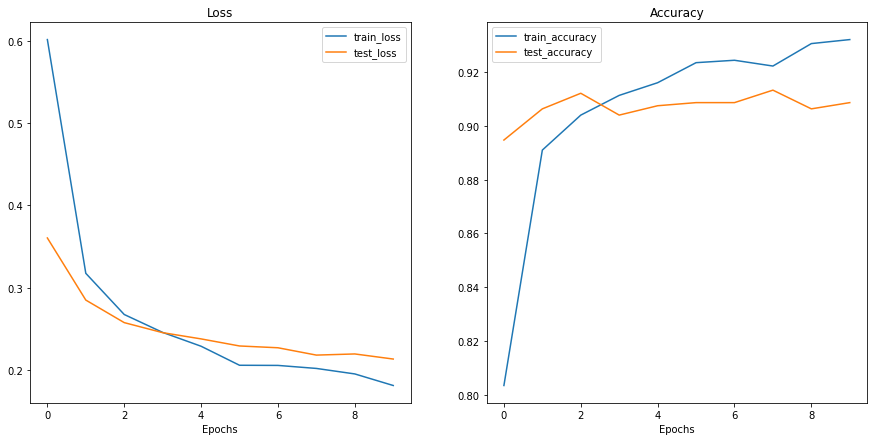

In [20]:
# Plot loss curves using plot_loss_curves function from utils.py
utils.plot_loss_curves(effnetb2_results)

# 4. Make predictions and evaluated the model

## 4.1. Make predictions in the test set

In [23]:
# Get a random list of images paths from test set
import random
from pathlib import Path
random.seed(0)

num_images_to_plot = 5
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images_to_plot)

test_image_path_sample

[PosixPath('/content/splitted_data/val/Healthy/Corn_Health (975).jpg'),
 PosixPath('/content/splitted_data/val/Healthy/Corn_Health (10).jpg'),
 PosixPath('/content/splitted_data/val/Gray_Leaf_Spot/Corn_Gray_Spot (113).jpg'),
 PosixPath('/content/splitted_data/val/Healthy/Corn_Health (1126).jpg'),
 PosixPath('/content/splitted_data/val/Common_Rust/Corn_Common_Rust (33).jpg')]

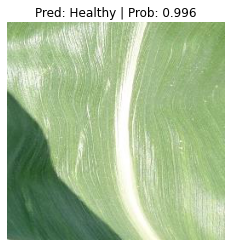

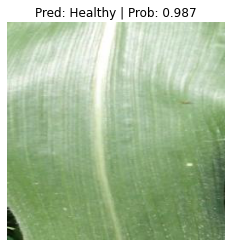

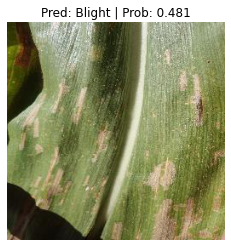

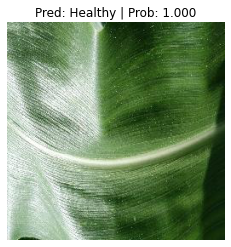

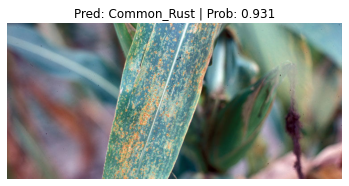

In [24]:
# Make predictions and plot images with pred_and_plot function from predictions.py
for image_test_path in test_image_path_sample:
  predictions.pred_and_plot_image(model = effnetb2,
                                  class_names = class_names,
                                  image_path = image_test_path,
                                  image_size = (224, 224),
                                  transform = effnetb2_transforms)

## 4.2. Get the "most wrong" predictions on the test dataset

In [25]:
# Create a function to return a list of dictionaries with sample, label, prediction and predicition probabilities
from tqdm.auto import tqdm

def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0) # transforms and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim = 1)
      pred_label = torch.argmax(pred_prob, dim = 1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)
  return test_pred_list

In [26]:
# Get the predictions on test dataset
test_pred_dicts = pred_and_store(test_paths = test_image_path_list,
                                 model = effnetb2,
                                 transform = effnetb2_transforms,
                                 class_names = class_names,
                                 device = device)

# Print the 5 most wrong predictions
test_pred_dicts[:5]

  0%|          | 0/334 [00:00<?, ?it/s]

[{'image_path': PosixPath('/content/splitted_data/val/Gray_Leaf_Spot/Corn_Gray_Spot (8).jpg'),
  'class_name': 'Gray_Leaf_Spot',
  'pred_prob': 0.9760845303535461,
  'pred_class': 'Blight',
  'correct': False},
 {'image_path': PosixPath('/content/splitted_data/val/Gray_Leaf_Spot/Corn_Gray_Spot (213).jpg'),
  'class_name': 'Gray_Leaf_Spot',
  'pred_prob': 0.71693354845047,
  'pred_class': 'Gray_Leaf_Spot',
  'correct': True},
 {'image_path': PosixPath('/content/splitted_data/val/Gray_Leaf_Spot/Corn_Gray_Spot (409).jpg'),
  'class_name': 'Gray_Leaf_Spot',
  'pred_prob': 0.976800799369812,
  'pred_class': 'Gray_Leaf_Spot',
  'correct': True},
 {'image_path': PosixPath('/content/splitted_data/val/Gray_Leaf_Spot/Corn_Gray_Spot (31).jpg'),
  'class_name': 'Gray_Leaf_Spot',
  'pred_prob': 0.6914853453636169,
  'pred_class': 'Blight',
  'correct': False},
 {'image_path': PosixPath('/content/splitted_data/val/Gray_Leaf_Spot/Corn_Gray_Spot (522).jpg'),
  'class_name': 'Gray_Leaf_Spot',
  'pred_p

In [27]:
# Trun the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,correct
0,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.976085,Blight,False
1,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.716934,Gray_Leaf_Spot,True
2,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.976801,Gray_Leaf_Spot,True
3,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.691485,Blight,False
4,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.876655,Gray_Leaf_Spot,True


In [28]:
# Incorrect predictions
incorrect_preds = test_pred_df[test_pred_df.correct == False]
incorrect_preds.head()

,image_path,class_name,pred_prob,pred_class,correct
0,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.976085,Blight,False
3,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.691485,Blight,False
7,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.506341,Common_Rust,False
8,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.597438,Common_Rust,False
10,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.512111,Common_Rust,False


In [29]:
# How many incorrect predcitions we get?
len(incorrect_preds)

43

In [30]:
# Sort DataFrame by corect than by the pred_prob
top_5_most_wrong = test_pred_df.sort_values(by = ["correct", "pred_prob"], ascending = [True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
0,/content/splitted_data/val/Gray_Leaf_Spot/Corn...,Gray_Leaf_Spot,0.976085,Blight,False
332,/content/splitted_data/val/Blight/Corn_Blight ...,Blight,0.916676,Gray_Leaf_Spot,False
272,/content/splitted_data/val/Common_Rust/Corn_Co...,Common_Rust,0.902244,Blight,False
319,/content/splitted_data/val/Blight/Corn_Blight ...,Blight,0.886267,Gray_Leaf_Spot,False
277,/content/splitted_data/val/Common_Rust/Corn_Co...,Common_Rust,0.866612,Blight,False


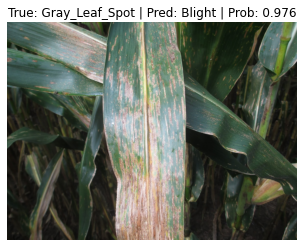

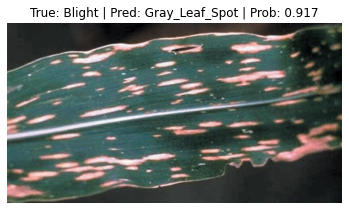

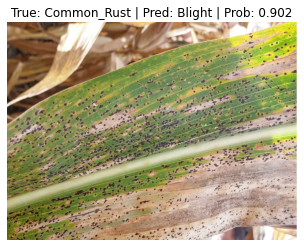

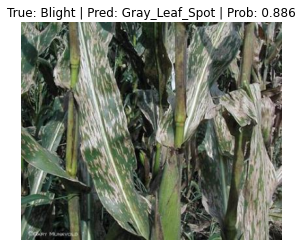

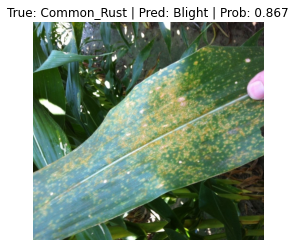

In [31]:
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]

  # Plot the image
  img = torchvision.io.read_image(str(image_path)) # Get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

Even though the predictions are incorrect, the model is not "doubting", since the probabilities are high.

## 4.3. Confusion matrix

In [32]:
# Make predictions on the entire test dataset
test_preds = []
effnetb2.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, Y in tqdm(test_dataloader):
    X, Y = X.to(device), Y.to(device)

    # Pass the data through the model
    test_logits = effnetb2(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim = 1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim = 1)

    # Add the pred labels to the test pred list
    test_preds.append(pred_labels)

# Concatenate the tests predas and put then on the CPU
test_preds = torch.cat(test_preds).cpu()

  0%|          | 0/27 [00:00<?, ?it/s]

In [33]:
# Get the truth labels for test dataset
test_truth = torch.cat([Y for X, Y in test_dataloader])

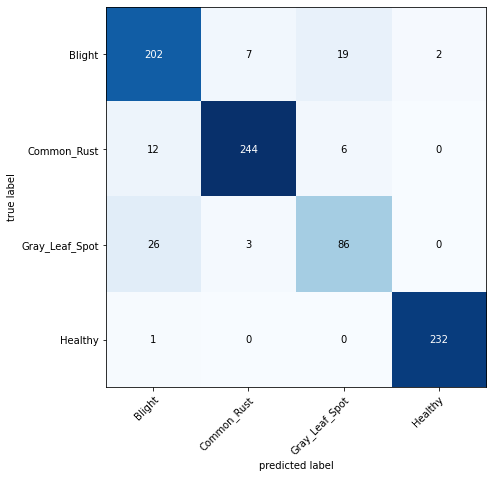

In [34]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task = "multiclass", num_classes = len(class_names))
confmat_tensor = confmat(preds = test_preds,
                         target = test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names = class_names,
    figsize = (10, 7)
)

The main incorrect predictions come from "Gray_Leaf_Spot" and "Blight". In favor of the model, we can say that both diseases present a similar pattern on the leaf (both cause brown lines along the leaf). 

## 4.4. Predictions on images from Internet

There will be a total of four images to test:
* [Common Rust](https://vegcropshotline.org/wp-content/uploads/2017/08/Southern-rust-2_Wise.jpg)
* [Blight](https://extension.umn.edu/sites/extension.umn.edu/files/styles/large/public/northernleafblight2_600px.jpg?itok=bdY09BXo)
* [Gray Leaf Spot](https://bugwoodcloud.org/images/768x512/5465613.jpg)
* [Leaf with thrip damage](https://nwdistrict.ifas.ufl.edu/phag/files/2013/06/Corn-Thrip-1-6-28-131.jpg) (for fun, because the model can't predict correctly).

In [ ]:
# Get the images
# Common Rust
!wget https://vegcropshotline.org/wp-content/uploads/2017/08/Southern-rust-2_Wise.jpg

# Blight
!wget https://extension.umn.edu/sites/extension.umn.edu/files/styles/large/public/northernleafblight2_600px.jpg?itok=bdY09BXo

# Gray leaf spot
!wget https://bugwoodcloud.org/images/768x512/5465613.jpg

# Thrip damage
!wget https://nwdistrict.ifas.ufl.edu/phag/files/2013/06/Corn-Thrip-1-6-28-131.jpg

In [36]:
# Get the image_paths
common_rust = "Southern-rust-2_Wise.jpg"
blight = "northernleafblight2_600px.jpg?itok=bdY09BXo"
gray_leaf_spot = "5465613.jpg"
thrip_damage = "Corn-Thrip-1-6-28-131.jpg"

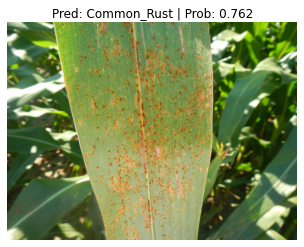

In [38]:
# Plot image and make predictions (Common Rust)
predictions.pred_and_plot_image(model = effnetb2,
                                class_names = class_names,
                                image_path = common_rust,
                                image_size = (224, 224),
                                transform = effnetb2_transforms,
                                device = device)

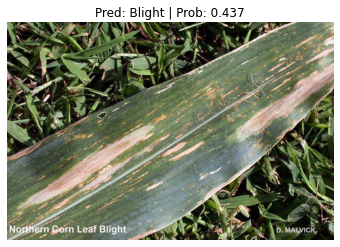

In [39]:
# Plot image and make predictions (Blight)
predictions.pred_and_plot_image(model = effnetb2,
                                class_names = class_names,
                                image_path = blight,
                                image_size = (224, 224),
                                transform = effnetb2_transforms,
                                device = device)

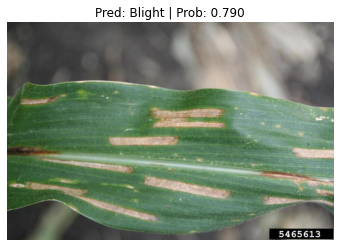

In [40]:
# Plot image and make predictions (Gray Leaf Spot)
predictions.pred_and_plot_image(model = effnetb2,
                                class_names = class_names,
                                image_path = gray_leaf_spot,
                                image_size = (224, 224),
                                transform = effnetb2_transforms,
                                device = device)

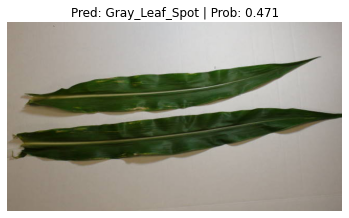

In [41]:
# Plot image and make predictions (Thrip damage)
predictions.pred_and_plot_image(model = effnetb2,
                                class_names = class_names,
                                image_path = thrip_damage,
                                image_size = (224, 224),
                                transform = effnetb2_transforms,
                                device = device)

The model failed to predict the corresponding image with Gray Leaf Spot, the same behavior we have seen in the model evaluation.

On the other hand, the other predictions (except for the damaged leaf) were correct. 

# Conclusions

Although the model has only been 90% accurate, it performs very well in predicting diseases such as common rust, although it fails in predicting Blight and Gray Leaf Spot. 

Future improvements can be added to the model, changing hyperparameters or adding data augmentation. Still, for a base model, the results are satisfactory. 